# Détermination des habitations connectables

***Auteur : Nicolas Matte, étudiant ingénieur à l'école des Mines, 2024***

Ce notebook est la suite de la partie sur le repérage des zones propices à l'installation d'un réseau de chaleur urbain. On fixe donc une telle zone, ici il s'agira de l'éco-quartier de Brétigny-sur-Orge.

In [1]:
# Imports

from shapely.geometry import shape, LineString
from shapely.ops import nearest_points
import fiona
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

## Extraction des données géographiques et énergétiques

Le procédé est presque le même que lors de la partie précédente en se restreignant à la zone ciblée grâce à l'outil `Intersection` de QGIS. Nous supposons que les données contiennent un et un seul bâtiment de propriété "ffo_bat_usage_niveau_1_txt" égale à "Production de chaleur" qui correspond à l'usine à chaleur.

In [2]:
buildings_file = "data/ecodistrict.gpkg"
roads_file = "data/roads_ecodistrict.gpkg"

# Extraction des routes
roads_fiona = fiona.open(roads_file)

roads = []

for road in roads_fiona:
    roads.append(road)

nb_roads = len(roads)
roads_fiona.close()

# Extraction des bâtiments
buildings_fiona = fiona.open(buildings_file)

buildings = []

for building in buildings_fiona:
    properties = building["properties"]
    if properties["ffo_bat_usage_niveau_1_txt"] == "Production de chaleur":
        # Il s'agit de l'usine à chaleur
        heat_plant = building
    if (properties["s_geom_groupe"] is not None) and (properties["dpe_conso_ener_mean"] is not None) and (properties["ffo_bat_annee_construction"] is not None) and (properties["bdtopo_bat_hauteur_mean"] >= 3): 
        buildings.append(building)

buildings_fiona.close()

print(len(buildings), "batiments ont été retenus.")

35 batiments ont été retenus.


Nous pouvons visualiser le quartier d'intérêt :
* En noir les routes
* Points bleu, les bâtiments
* Point rouge, l'usine à chaleur

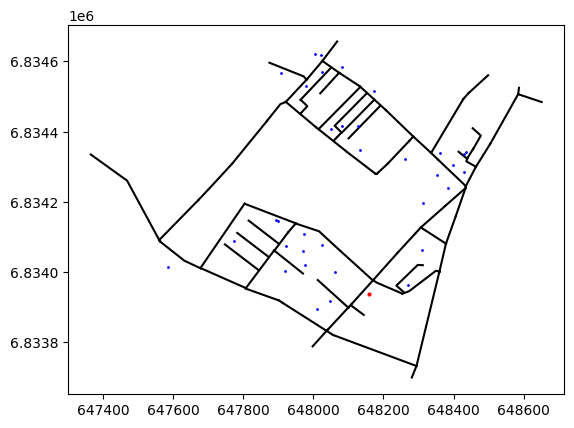

In [3]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    # Tracé des routes
    x_ligne1, y_ligne1 = zip(*road["geometry"]["coordinates"][0])
    plt.plot(x_ligne1, y_ligne1, color="black")

# Représentation des bâtiments par des points
for building in buildings:
    polygon_batiment = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid_x, centroid_y = polygon_batiment.centroid.xy
    plt.plot(centroid_x, centroid_y, 'bo', markersize=1)

# Représentation de l'usine à chaleur
polygon_plant = shape(heat_plant["geometry"])
centroid_x, centroid_y = polygon_plant.centroid.xy
plt.plot(centroid_x, centroid_y, "ro", markersize=2);

## Détermination des bâtiments connectables

Choisir les bâtiments qui seront raccordés au réseau de chaleur n'est pas un problème à solution absolue ni unique. Il faut prendre en compte une multitude de paramètres :
* Budget de la mairie
* Offre en chaleur disponible
* Consommation des bâtiments : est-il rentable de les raccorder ?
* Carbonation de la chaleur actuellement distribuée aux bâtiments
* Objectifs de la municipalité, pression d'autres acteurs...

L'agent municipal peut ainsi éliminer à la main certains groupes de bâtiments, mais il peut également se fier à certains critères de priorité pour le raccordement, notamment la demande en chaleur. En effet, pour avoir un réel impact et augmenter sa rentabilité, le réseau de chaleur doit pouvoir subvenir à la plus grande demande en chaleur possible.

Ainsi, la méthode que nous proposons en tant qu'agent municipal est la suivante :
1. Eliminer ou inclure d'office certains groupes de bâtiments à la main;
2. Déterminer un critère de consommation minimale pour définir le reste des bâtiments connectables;

### 1. Eliminer ou inclure d'office certains groupes de bâtiments à la main

L'agent municipal doit parfois suivre certaines directives stratégiques, par exemple raccorder certains groupes de bâtiments prioritaires ou bien le tertiaire qui participe au financement du projet. Il peut également avoir conscience de certaines choses non prises en compte par l'ordinateur : certains bâtiments seront bientôt détruits, d'autres bientôt construits, certains sont déjà connectés à d'autres infrastructures performantes...  

On modélise les décisions de l'agent municipal par deux liste d'indices `eliminated_index` et `imposed_index` qui correspondent respectivement aux bâtiments éliminés et raccordés d'office par l'agent municipal.  

### 2. Déterminer un critère de consommation minimale pour définir le reste des bâtiments connectables

Un tel critère est défini sur le site **France Chaleur** : au-delà de $30kW$, un bâtiment doit dans la plupart des cas être considéré pour le tracé du réseau de chaleur.

La puissance thermique maximale demandée par les habitations est estimée grâce à une technique définie dans la section suivante. On réalisera alors le filtrage des bâtiments selon ce critère.

Ce procédé permet de trouver le compromis entre une demande raccordée maximale en premier plan et un nombre de bâtiments raccordé minimal afin de limiter les coûts.

# Application à l'écoquartier de Brétigny-sur-Orge

## Estimation de la consommation énergétique annuelle moyenne

Le procédé est le même que dans le notebook précédent.

In [4]:
# Calcul des demandes en chaleur pour tous les bâtiments retenus

h_0 = 3 # mètres, taille d'un étage

nb_buildings = len(buildings) # Attention à la redondance des noms de variable dans le notebook
heat_demands = np.zeros(nb_buildings)

for k, building in enumerate(buildings):
    properties = building["properties"]
    Q = properties["dpe_conso_ener_mean"] * properties["s_geom_groupe"] * int(properties["bdtopo_bat_hauteur_mean"] / h_0)
    heat_demands[k] = Q

# Tri suivant les consommations décroissantes
sorted_index = np.argsort(heat_demands)[::-1]
heat_demands = np.sort(heat_demands)[::-1]
buildings = [buildings[index] for index in sorted_index]

## Sélection des bâtiments les plus demandeurs

Un critère pour labelliser un réseau de chaleur urbain est de raccorder systématiquement les bâtiments ayant une demande en puissance maximale supérieure à 30kW.

### Courbes des demandes en puissance thermique

Afin de réaliser la simulation d'un réseau de chaleur avec le logiciel Dymola, il faut estimer leurs demandes instantanées tout au long de l'année. Pour cela, nous utilisons la méthode décrite dans les sections suivantes.

#### Utiliser des profils typiques de demande en chaleur

Nous disposons de trois fichiers correspondant aux courbes typiques des bâtiments construits durant les périodes suivantes :
* Avant 1989 (exclu) : `RT_1974_Treated.csv` (il s'agit en réalité des normes des bâtiments construits entre 1974 et 1989);
* Entre 1989 (inclus) et 2005 (exclu) : `RT_1989_Trated.csv` (il s'agit des normes des bâtiments construits entre 1989 et 2005);
* Après 2005 (inclus) : `RT_2005_Treated.csv`.

Il s'agit de timeseries que nous allons manipuler avec `pandas`.

In [5]:
heat_profile_1974 = pd.read_csv("data/RT_1974_Treated.csv", index_col=0)
heat_profile_1989 = pd.read_csv("data/RT_1989_Treated.csv", index_col=0)
heat_profile_2005 = pd.read_csv("data/RT_2005_Treated.csv", index_col=0)

#### Visualisation des données

Il a été vérifié qu'il ne manque aucune donnée dans les timeseries.

In [6]:
heat_profile_1974.head()

,Text,Tindoor,Tdepart,Tretour,Debit_eau,Conso_energetique_integrale
ElapsedTime,,,,,,
0,1.273,17.744,291.691,289.249,0.192,0.064
3600,1.232,17.565,308.755,302.356,0.200,0.894
7200,1.374,19.084,316.640,311.968,0.200,2.493
10800,1.431,19.692,317.198,312.491,0.200,3.868
14400,1.313,19.995,317.443,312.777,0.200,5.269


Pour les trois fichiers, nous disposons des données physiques suivantes par intervalles de temps de $3600s$ :
* $T_{ext}$ est la température de l'air extérieur ($°C$);
* $T_{indoor}$ est la température à l'intérieur du bâtiment ($°C$);
* $T_{depart}$ est la température demandée par le bâtiment, elle correspond à la température de l'eau en début de circuit secondaire, c'est-à-dire juste en aval de l'échangeur de chaleur avec le circuit primaire ($°C$);
* $T_{retour}$ est réciproquement la température de l'eau du circuit secondaire en amont de l'échangeur de chaleur avec le circuit primaire ($°C$);
* $Debit_{eau}$ est le débit massique d'eau du circuit secondaire ($kg.s^{-1}$);
* $Conso \: Energetique \: Integrale$ ne nous intéressera pas.

#### Calcul de la puissance thermique demandée

##### Théorie

Les lois de la thermodynamique conduisent à l'équation suivante :
$$
\Phi_{th} = D_m c_p (T_{départ} - T_{retour})
$$

avec :
* $\Phi_{th}$ la puissance thermique fournie par l'eau à l'air intérieur de l'habitation ($W$);
* $D_m$ le débit massique d'eau dans le circuit secondaire ($kg.s^{-1}$);
* $c_p$ la capacité thermique massique de l'eau, supposée constante et égale à $4180 J.K^{-1}.kg^{-1}$;

Or, nous devons respecter une contrainte : la consommation énergétique annuelle doit être égale à l'approximation que nous en avons faite beaucoup plus tôt.
$$
Q_{total} = \sum_{1 an} \Phi_{th} . \Delta t = (\sum_{1 an} \Phi_{th}) . \Delta t
$$
où $\Delta t$ est le pas de temps constant et égal à $3600s$, soit $1h$

Nous allons donc ajuster via un facteur multiplicatif le débit d'eau afin de satisfaire à cette contrainte. L'hypothèse sous-jacente est que, même si un bâtiment est plus volumineux qu'un autre, s'ils ont été construits durant la même période alors leurs courbes de demande en chaleur ont des formes similaires. Nous allons donc poser $\Phi_{th} = \alpha \Phi_{th,\: type}$ afin de se ramener à nos données typiques.

$$
\begin{align}
Q_{total} &= \alpha (\sum_{1 an} \Phi_{th,\: type}) . \Delta t \\
\Leftrightarrow \alpha &= \frac{Q_{total}}{( \sum_{1 an} \Phi_{th,\: type} ) . \Delta t} \\
\end{align}
$$

Finalement, on peut ajuster le débit d'eau du circuit secondaire en posant :

$$
D_m = \alpha D_{m,\: type}
$$

La valeur du coeff ainsi que la date de construction seront accessibles pour chaque bâtiment relié au réseau de chaleur, via les propriétés respectives `heat_profile_coeff` et `construction_date`.

##### Pratique

In [7]:
# Tableau des coefficients alpha
heat_profile_coeff_tab = np.zeros(nb_buildings)

# Constantes
cp_water = 4180 # J/K/kg
delta_t = 1 # h (l'énergie est en kWh)

# Initialisation
sum_power = np.zeros(3)

# Fonction pour catégoriser les bâtiments suivant leur année de construction
def categorize(building):
    construction_date = building["properties"]["ffo_bat_annee_construction"]
    # 0 : avant 1989 exclu
    if construction_date < 1989:
        return 0
    # 1 : entre 1989 inclus et 2005 exclu
    elif 1989 <= construction_date < 2005:
        return 1
    # 2 : après 2005 exclu
    else:
        return 2
    
df_tab = [heat_profile_1974, heat_profile_1989, heat_profile_2005]

# Calcul de la colonne des puissances dans les dataframes de référence
def add_power_column(df):
    df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)
    
for k, df in enumerate([heat_profile_1974, heat_profile_1989, heat_profile_2005]):
    # Ajout de la colonne puissance
    add_power_column(df)
    # Calcul de la somme des puissances
    sum_power[k] = df.Puissance.sum()

# Calcul des coefficients pour chaque bâtiment hors usine à chaleur
for k, building in enumerate(buildings):
    category = categorize(building)
    heat_profile_coeff_tab[k] = heat_demands[k] / (delta_t * sum_power[category] * 1e-3) # attention unités : kWh / kWh

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_82608\3192598625.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)


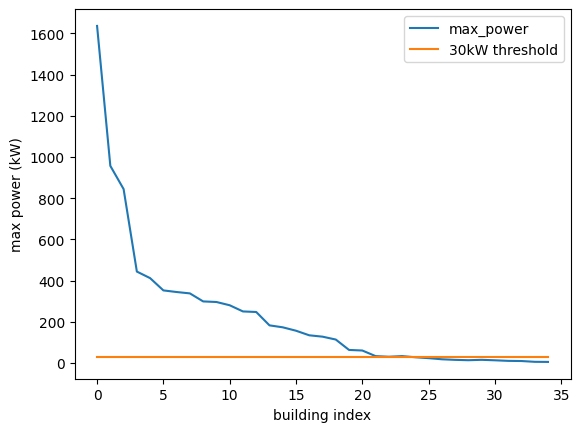

In [8]:
# Tableau du max des puissances pour chaque bâtiment
max_power = np.zeros(nb_buildings)
for k, building in enumerate(buildings):
    max_power[k] = heat_profile_coeff_tab[k] * np.max(df_tab[categorize(building)].Puissance)
plt.plot(max_power*1e-3, label="max_power")
plt.plot([30 for _ in range(nb_buildings)], label="30kW threshold")
plt.xlabel("building index")
plt.ylabel("max power (kW)")
plt.legend();

#### Filtrage des bâtiments

In [9]:
mask = np.array([power > 30e3 for power in max_power])
buildings = [buildings[k] for k in range(nb_buildings) if mask[k]]
nb_buildings = len(buildings)
print(nb_buildings)

24


#### Permutation de l'ordre de priorité des bâtiments

**A n'exécuter que pour obtenir un tracé différent de celui obtenu par défaut en classant les bâtiments par consommation annuelle décroissante.**

In [10]:
# permutation de l'ordre des bâtiments
# permutation = np.arange(nb_buildings)
# np.random.shuffle(permutation)
# y = [buildings[permutation[k]] for k in range(nb_buildings) ]
# buildings = y

## Modélisation du quartier par un graphe

### Définition des noeuds

Les listes `buildings` et `roads` doivent avoir été définies avant d'exécuter cette partie.  

On définit deux types de noeuds qui possédent de nombreuses propriétés de trois types : topologiques, énergétiques et relatives au réseau de chaleur. On compte comme type de noeud :
* Les bâtiments
* Les routes

Une telle représentation permet de grandement simplifier l'écriture du code.

In [11]:
lambda_ = 1.5e3 # kWh/m/an

class Node_building:
    # Un bâtiment sera représenté par un indice et l'objet bâtiment qui y est associé
    def __init__(self, index):
        self.index = index
        self.building = buildings[index]
        self.coordinates = self.building["geometry"]["coordinates"][0][0]
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "batiment"
        self.predecessor = None
        properties = self.building["properties"]
        self.heat_demand = properties["dpe_conso_ener_mean"] * properties["s_geom_groupe"] * int(properties["bdtopo_bat_hauteur_mean"] / h_0)
        self.radius = self.heat_demand / lambda_
        self.construction_date = properties["ffo_bat_annee_construction"]
        self.heat_profile_coeff = heat_profile_coeff_tab[index]

class Node_road:
    # Une route sera représentée par un indice et l'objet route qui y est associée
    def __init__(self, index):
        self.index = index
        self.road = roads[index]
        self.coordinates = self.road["geometry"]["coordinates"][0]
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "route"
        self.predecessor = None
        self.length = shape(self.road["geometry"]).length

class Node_plant:
    # L'usine à chaleur sera représenté par un indice et l'objet bâtiment qui y est associée
    # Différence avec les noeuds bâtiments : ni demande en chaleur ni rayon caractéristique, index = nb_buildings pour le distinguer et ce sera le dernier dans les listes
    def __init__(self, heat_plant=heat_plant):
        self.index = nb_buildings
        self.building = heat_plant
        self.coordinates = heat_plant["geometry"]["coordinates"][0][0]
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "production de chaleur"
        self.predecessor = None

### Modélisation des arêtes

La présence d'une arête entre deux noeuds signifie qu'un tuyau peut joindre directement ces derniers en suivant la route et sans croiser de noeud intermédiaire. Il y a ainsi deux types de noeuds :
* Entre deux tronçons de routes successifs;
* Entre un bâtiment et une route qui lui est proche.

Nous avons fait le choix de ne raccorder que depuis la route les bâtiments, on exclut donc la possibilité de réaliser des tuyaux entre les habitations. Il y aura donc éventuellement une légère surestimation du coût du réseau de chaleur qu'il faudra prendre en compte lors de la présentation du projet.

Les arêtes seront modélisées par des tables d'adjacence représentées par des dictionnaires Python. Il s'agit certes de structures redondantes, mais nous les avons choisi pour leur grande efficacité en terme de temps de calcul. L'encombrement mémoire ne représentera par ailleurs pas un problème étant donnée la faible taille du graphe étudié (de l'odre du millier de noeuds).

### Construction du graphe

Les règles sont les suivantes pour calculer les arêtes :
1. Deux routes sont connectées si et seulement si la distance minimale entre ces dernières est inférieure à 5m;
2. Un bâtiment est connecté à sa route la plus proche.

In [12]:
# Construction du graphe

# Liste des noeuds bâtiments
list_nodes_buildings = [Node_building(index) for index in range(0, nb_buildings)] + [Node_plant(heat_plant)]
# Liste des noeuds routes
list_nodes_roads = [Node_road(index) for index in range(nb_roads)]
# Liste des arêtes entre les routes initialisée vide
list_edges_roads = {road.index : [] for road in list_nodes_roads}
# Liste des arêtes entre routes et bâtiments initialisée vide
list_edges_buildings = {building.index : [] for building in list_nodes_buildings}
# Liste des arêtes entre routes et bâtiments, mais dans l'autre sens
list_edges_roads_buildings = {road.index : [] for road in list_nodes_roads}

# Relier les routes entre elles à 5m près
for road1 in list_nodes_roads:
    for road2 in list_nodes_roads[road1.index+1:]:

        line1 = LineString(road1.coordinates)
        line2 = LineString(road2.coordinates)

        # Calculer la distance minimale entre les deux routes
        minimal_distance = line1.distance(line2)

        # On relie si cette distance est inférieure à 5m
        if minimal_distance <= 5:
            list_edges_roads[road1.index].append(road2)
            list_edges_roads[road2.index].append(road1)
            
# Relier les bâtiments et l'usine à chaleur à la route la moins éloignée
for building in (list_nodes_buildings):
    is_connected = False
    closest_road = list_nodes_roads[0]
    closest_road_distance = 10000
    for road in list_nodes_roads:

        line1 = LineString(building.coordinates)
        line2 = LineString(road.coordinates)

        # Calculer la distance minimale entre le bâtiment et la route
        minimal_distance = line1.distance(line2)

        if minimal_distance < closest_road_distance:
            closest_road_distance = minimal_distance
            closest_road = road
    
    # On connecte à la route la plus proche
    list_edges_buildings[building.index].append((closest_road, closest_road_distance))
    list_edges_roads_buildings[closest_road.index].append((building, closest_road_distance))
    is_connected = True # Ligne inutile mais facilite la lecture

### Visualisation du graphe

Il est important de visualiser régulièrement ce que l'on fait afin d'éviter toute aberration.

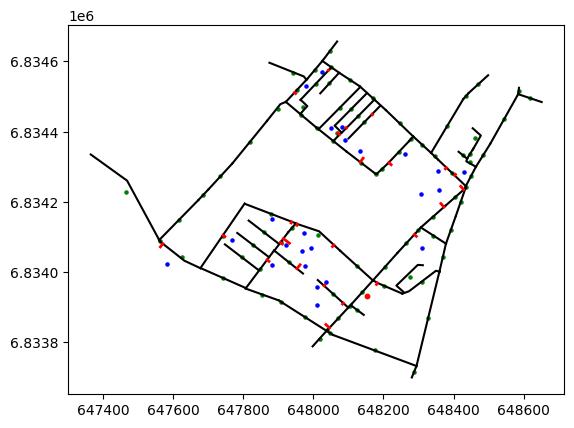

In [13]:
# Représentation graphique - batiments en rouge, routes en bleu (points), le tout relié. Si c'est assez lisible,
# on ajoutera dans un second temps le tracé des routes

# Tracé des routes et positionnement des noeuds de route
for road in list_nodes_roads:
    # Tracé des routes
    x_line1, y_line1 = zip(*road.coordinates)
    plt.plot(x_line1, y_line1, color="black")
    # Positionnement des noeuds de route
    plt.scatter(road.center[0], road.center[1], color="green", s=5)

# Positionnement des noeuds de bâtiments
for building in list_nodes_buildings:
    if building.type == "production de chaleur":
        plt.scatter(building.center[0], building.center[1], color="red", s=10)
    else:
        plt.scatter(building.center[0], building.center[1], color="blue", s=5)

# Arêtes entre routes et bâtiments
for building in list_nodes_buildings:
    edges = list_edges_buildings[building.index]
    building = list_nodes_buildings[building.index]
    for road, _ in edges:
        geom1 = shape(building.building["geometry"])
        geom2 = shape(road.road["geometry"])
        nearest_points_obj1_to_obj2 = nearest_points(geom1, geom2)

        # Extraire les coordonnées des points les plus proches
        x_coords = [point.x for point in nearest_points_obj1_to_obj2]
        y_coords = [point.y for point in nearest_points_obj1_to_obj2]

        # Tracer la ligne reliant les deux points
        plt.plot(x_coords, y_coords, color='red', linewidth=2)

Il faut avoir conscience du fait que, bien que l'on prenne en compte dans les calculs les formes des bâtiments, ces dernières ne sont ici pas représentées. Ainsi, les points que l'on observe sont situés au niveau du barycentre de chaque noeud (bâtiment comme route).

## Implémentation de l'algorithme de tracé

Tout est codé dans la classe `Graph` implémentée ci-dessous. Quelques points pour décrire les outils implémentés :
* Le réseau de chaleur est initialisé au seul noeud de production
* Le critère de raccordabilité est toujours vérifié et mis à jour
* La connexion entre deux bâtiments est effectuée en suivant le plus court chemin dans un espace métrique où l'on suit les routes et où les routes déjà traversées par le réseau sont de longueurs nulles (les distances sont donc actualisées dynamiquement).

In [14]:
class Graph:

    def __init__(self, list_nodes_buildings, list_nodes_roads, list_edges_buildings, list_edges_roads, list_edges_roads_buildings):
        self.list_nodes_buildings = list_nodes_buildings
        self.list_nodes_roads = list_nodes_roads
        self.list_edges_buildings = list_edges_buildings
        self.list_edges_roads = list_edges_roads
        self.list_edges_roads_buildings = list_edges_roads_buildings
        self.nb_buildings = len(self.list_nodes_buildings) - 1
        self.nb_roads = len(self.list_nodes_roads)
        self.dhn_roads = np.full(self.nb_roads, False) # DHN : district heat network
        self.dhn_buildings = np.full(self.nb_buildings, False)
        self.radii = np.zeros(nb_buildings)
        self.network_radius = 0
        self.loop_test = False

    def initialise_radii(self):
        for building in self.list_nodes_buildings[:-1]:
            self.radii[building.index] = building.radius

    def connect_network(self, building, verbose=False):
        """
        Connecte building depuis l'usine à chaleur en remontant le plus court chemin
        grâce aux prédecesseurs (calculés en amont de cette fonction avec shortest_way !)
        """
        if verbose:
            print("Connexion au réseau du bâtiment :", building.index)
        # Indiquer le bâtiment comme connecté
        self.dhn_buildings[building.index] = True
        # Trouver la rue connectée à building située sur le plus court chemin entre building et l'usine à chaleur
        node = building.predecessor
        while node.type != "production de chaleur":
            if node.type == 'route':
                if verbose and not self.dhn_roads[node.index]:
                    print("Connexion de la route", node.index)
                # On remonte le plus court chemin jusqu'à revenir à building
                self.dhn_roads[node.index] = True
            node = node.predecessor

    def reinitialise_predecessors(self):
        for building in self.list_nodes_buildings:
            building.predecessor = None
        

    def shortest_way(self, initial_builing, list_buildings, verbose=False):
        verbose = False
        # Algorithme de Djikstra, termine lorsque les batiments de liste_batiments ont été parcourus
        if verbose:
            print("Calcul du plus court chemin depuis le batiment numéro:", initial_builing.index)
        # Réinitialisation des prédecesseurs
        self.reinitialise_predecessors()
        # Initialisation
        list_index = [building.index for building in list_buildings]
        distances_buildings = np.full(self.nb_buildings + 1, np.inf)
        distances_roads = np.full(self.nb_roads, np.inf)
        buildings_to_cross = np.full(self.nb_buildings + 1, True)
        roads_to_cross = np.full(self.nb_roads, True)
        
        distances_buildings[initial_builing.index] = 0

        # Itérations - tant que les batiments de list_buildings n'ont pas tous été parcourus
        while np.any(buildings_to_cross[list_index]):
            # Nous allons calculer le noeud de plus petite distance en comparant celui de type Node_building et celui de type Node_road (tous deux de plus petite distance par rapport à leurs semblables)

            # Il reste nécessairement des noeuds de bâtiments à parcourir
            # On choisit le noeud non parcouru de plus petite distance de type bâtiment
            mask_buildings = buildings_to_cross & (distances_buildings == np.min(distances_buildings[buildings_to_cross])) # tableau de booléens dont les composantes valent True ssi le bâtiment n'a pas été parcouru et est de plus petite distance
            index_building = np.argmax(mask_buildings) # Calcule l'indice de la première occurence de True dans le tableau précédent
            # On stocke la distance correspondante
            minimal_distance_buildings = distances_buildings[index_building] 

            # S'il reste des noeuds de routes à parcourir
            if np.any(roads_to_cross):
                # On choisit le noeud non parcouru de plus petite distance de type route
                mask_roads = roads_to_cross & (distances_roads == np.min(distances_roads[roads_to_cross]))
                index_road = np.argmax(mask_roads)
                minimal_distance_roads = distances_roads[index_road]
                # test = "Le noeud non parcouru de plus petite distance est-il un bâtiment ?"
                test = minimal_distance_buildings <= minimal_distance_roads
            # S'il n'y a plus de routes à parcourir, alors on dit que test est vrai pour parcourir le noeud bâtiment de plus petite distance
            else :
                test = True
            
            # CAS 1 : le noeud de plus petite distance est un bâtiment
            if test:
                # current_building est le bâtiment correspondant à cette distance
                current_building = self.list_nodes_buildings[index_building]
                # On l'indique comme parcouru
                buildings_to_cross[index_building] = False
                if verbose:
                    print("Batiment actuel :", index_building)
                # On parcourt les noeuds voisins non parcourus (routes)
                for road, length in self.list_edges_buildings[index_building]:
                    # On teste si le noeud n'a pas été parcouru
                    if roads_to_cross[road.index]:
                        # Minimisation du chemin
                        new_distance = distances_buildings[index_building] + length
                        if distances_roads[road.index] > new_distance:
                            distances_roads[road.index] = new_distance
                            road.predecessor = current_building
            
            # CAS 2 : le noeud de plus petite distance est une route
            else:
                # current_road est la route correspondant à cette distance
                current_road = self.list_nodes_roads[index_road]
                # On l'indique comme parcourue
                roads_to_cross[index_road] = False
                if verbose:
                    print("Route actuelle :", index_road)
                # On détermine la longueur de tuyaux à ajouter sur la route actuelle
                if self.dhn_roads[current_road.index]:
                    length_road = 0
                else:
                    length_road = current_road.length
                # On parcourt les routes voisines non parcourues
                for road in self.list_edges_roads[index_road]:
                    if roads_to_cross[road.index]:
                        # Minimisation du chemin
                        new_distance = distances_roads[index_road] + length_road
                        if distances_roads[road.index] > new_distance:
                            distances_roads[road.index] = new_distance
                            road.predecessor = current_road
                # On parcourt les batiments voisins non parcourus
                for building, length in self.list_edges_roads_buildings[index_road]:
                    if buildings_to_cross[building.index]:
                        # Minimisation du chemin
                        new_distance = distances_roads[index_road] + length + length_road
                        if distances_buildings[building.index] > new_distance:
                            distances_buildings[building.index] = new_distance
                            building.predecessor = current_road
            
        return { list_index[k] : distances_buildings[k] for k in range(len(list_index)) }
      
            
    def compute_dhn(self, verbose=False):
        # Initialisation de la file de parcours des bâtiments, dans l'ordre de la conso énergétique décroissante
        self.queue = list(np.arange(self.nb_buildings))
        # Initialisation d'une liste pour savoir quels bâtiments ont déjà été parcourus
        self.were_crossed_buildings = np.full(self.nb_buildings, 0)
        # Réinitialisation des rayons
        self.initialise_radii()
        self.network_radius = 0
        # Réinitialisation du réseau de chaleur
        self.dhn_buildings = np.full(self.nb_buildings + 1, False)
        self.dhn_roads = np.full(self.nb_roads, False)
        # Le réseau est initialisé au noeud de l'usine à chaleur
        self.dhn_buildings[-1] = True
        # On parcourt tous les bâtiments (hors usine à chaleur)
        while len(self.queue) > 0:
            # On prend le premier bâtiment dans la file d'attente
            index = self.queue[0]
            if verbose:
                print("Tentative de connexion du bâtiment :", index)
            current_building = self.list_nodes_buildings[index]
            # Calcule sa distance au réseau de chaleur
            distance_network = self.shortest_way(self.list_nodes_buildings[-1], [current_building], verbose=verbose)[index]
            # Si le raccord est économiquement viable, on l'effectue
            if self.radii[index] + self.network_radius >= distance_network:
                # Raccord
                self.connect_network(current_building, verbose=verbose)
                # Actualisation du rayon du réseau de chaleur
                self.network_radius += self.radii[index] - distance_network
                # On indique que le dernier bâtiment a avoir été raccordé l'a été après x tentatives
                self.loop_test = self.were_crossed_buildings[index]
            # Sinon, on remet le bâtiment au fond de la file à condition qu'un bâtiment a été connecté lors de la dernière boucle
            elif self.loop_test >= self.were_crossed_buildings[index] - 1:
                # Ajout à la file
                self.queue.append(index)
                # On indique que le bâtiment a été parcouru une fois de plus
                self.were_crossed_buildings[index] += 1
            # Dernier cas, le bâtiment ne sera pas raccordé au réseau
            else:
                pass
            # On retire current_building de la file
            self.queue.pop(0)

## Application de l'algorithme - tracé du réseau de chaleur

In [15]:
G = Graph(list_nodes_buildings, list_nodes_roads, list_edges_buildings, list_edges_roads, list_edges_roads_buildings)
G.compute_dhn(verbose=True)

Tentative de connexion du bâtiment : 0
Tentative de connexion du bâtiment : 1
Tentative de connexion du bâtiment : 2
Tentative de connexion du bâtiment : 3
Tentative de connexion du bâtiment : 4
Tentative de connexion du bâtiment : 5
Tentative de connexion du bâtiment : 6
Tentative de connexion du bâtiment : 7
Connexion au réseau du bâtiment : 7
Connexion de la route 50
Connexion de la route 73
Connexion de la route 51
Connexion de la route 76
Connexion de la route 77
Connexion de la route 45
Connexion de la route 71
Connexion de la route 43
Connexion de la route 40
Connexion de la route 72
Connexion de la route 37
Connexion de la route 19
Tentative de connexion du bâtiment : 8
Tentative de connexion du bâtiment : 9
Connexion au réseau du bâtiment : 9
Connexion de la route 3
Connexion de la route 52
Connexion de la route 48
Connexion de la route 80
Tentative de connexion du bâtiment : 10
Tentative de connexion du bâtiment : 11
Connexion au réseau du bâtiment : 11
Connexion de la route 

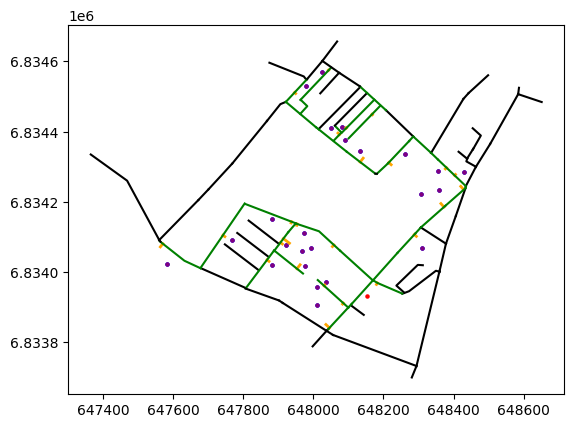

In [16]:
# Affichage du RCU

# Affichage de tous les bâtiments
for building in G.list_nodes_buildings:
    if building.type == "production de chaleur":
        plt.scatter(building.center[0], building.center[1], color="red", s=5)
    else:
        plt.scatter(building.center[0], building.center[1], color="blue", s=5)

# Arêtes entre routes et bâtiments
for index in range(G.nb_buildings+1):
    if G.dhn_buildings[index]:
        edges = list_edges_buildings[index]
        building = list_nodes_buildings[index]
        # Coloration en violet du bâtiment, sauf pour l'usine à chaleur
        if index < G.nb_buildings:
            x1, y1 = building.center
            plt.scatter(x1, y1, color="purple", s=5)
        for road, _ in edges:
            geom1 = shape(building.building["geometry"])
            geom2 = shape(road.road["geometry"])
            nearest_points_obj1_to_obj2 = nearest_points(geom1, geom2)

            # Extraire les coordonnées des points les plus proches
            x_coords = [point.x for point in nearest_points_obj1_to_obj2]
            y_coords = [point.y for point in nearest_points_obj1_to_obj2]

            # Tracer la ligne reliant les deux points
            plt.plot(x_coords, y_coords, color='orange', linewidth=2)


# Coloration des routes connectées
for road in G.list_nodes_roads:
    if G.dhn_roads[road.index]:
        color = "green"
    else:
        color = "black"
    x_ligne1, y_ligne1 = zip(*road.coordinates)
    plt.plot(x_ligne1, y_ligne1, color=color)

Légende :
* Point violet : bâtiment raccordé
* Point bleu : bâtiment non raccordé
* Point rouge : usine à chaleur
* Ligne verte : route raccordée
* Ligne noire : route non raccordée
* Ligne jaune : tuyaux entre une route et un bâtiment

Remarque : l'algorithme est faible face à plusieurs routes proches et parallèles.